# Assignment 2: Using Neural Networks to Sort Fashionably 

Required libraries for this assignment:

In [105]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, ParameterGrid
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler, Dataset
from sklearn.model_selection import StratifiedShuffleSplit
from concurrent.futures import ThreadPoolExecutor
from torch.cuda.amp import autocast, GradScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torchvision import transforms as T
from sklearn.decomposition import PCA
from collections import defaultdict
import torchvision.models as models
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from collections import Counter
import matplotlib.pyplot as plt
from functools import partial
from torch import nn, optim
import scipy.stats as ss
from tqdm import tqdm
import seaborn as sns
from PIL import Image
import pandas as pd
import numpy as np
import zipfile
import random
import torch
import copy
import os

## Part I: Common Groundwork - Data Preparation and Understanding

### Dataset Preparation & Initial Analysis

1. Manually partitioned train.csv into training (80%) and validation (20%) subsets with random seed
2. Implemented ImageDressDataset class as per requirements mentioned.
3. Visualized some examples from the dataset

In [106]:
train_df = pd.read_csv('./train_2025.csv')
test_df = pd.read_csv ('./test_2025.csv')
train_df, valid_df  = train_test_split(train_df, test_size = 0.2, random_state = 42)

print(train_df.shape)
print(valid_df.shape)

(10821, 13)
(2706, 13)


In [107]:
#Unzip the image file
zip_path = "/lustre/home/lsivakumar/LLMItemDiscovery/images.zip"
extract_dir = "./images/raw"

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted to {extract_dir}")

Extracted to ./images/raw


In [230]:
class ImageDressDataset(Dataset):  # custom datset class
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)    # read the CSV file to get a list of (filenames, labels)
        self.img_dir = img_dir
        self.transform = transform
        
        if self.df['garment_types'].dtype == 'object':
            unique_labels = self.df['garment_types'].unique()
            self.label_map = {label: idx for idx, label in enumerate(unique_labels)}
            self.df['label'] = self.df['garment_types'].map(self.label_map)   #mapping feature
        else:
            self.df['label'] = self.df['garment_types']

    def __len__(self):
        return len(self.df) # return the total number of images in this instance

    def __getitem__(self, idx):
        img_name = self.df.loc[idx, 'article_id']
        label = self.df.loc[idx, 'label'] 
        img_path = f"{self.img_dir}/{img_name}.jpg" #construct full path to image
        image = Image.open(img_path).convert('RGB') #load from path
        if self.transform:
            image = self.transform(image)
        return image, label

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

In [109]:
dataset = ImageDressDataset(dataframe=train_df, img_dir='./images/raw', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=3)

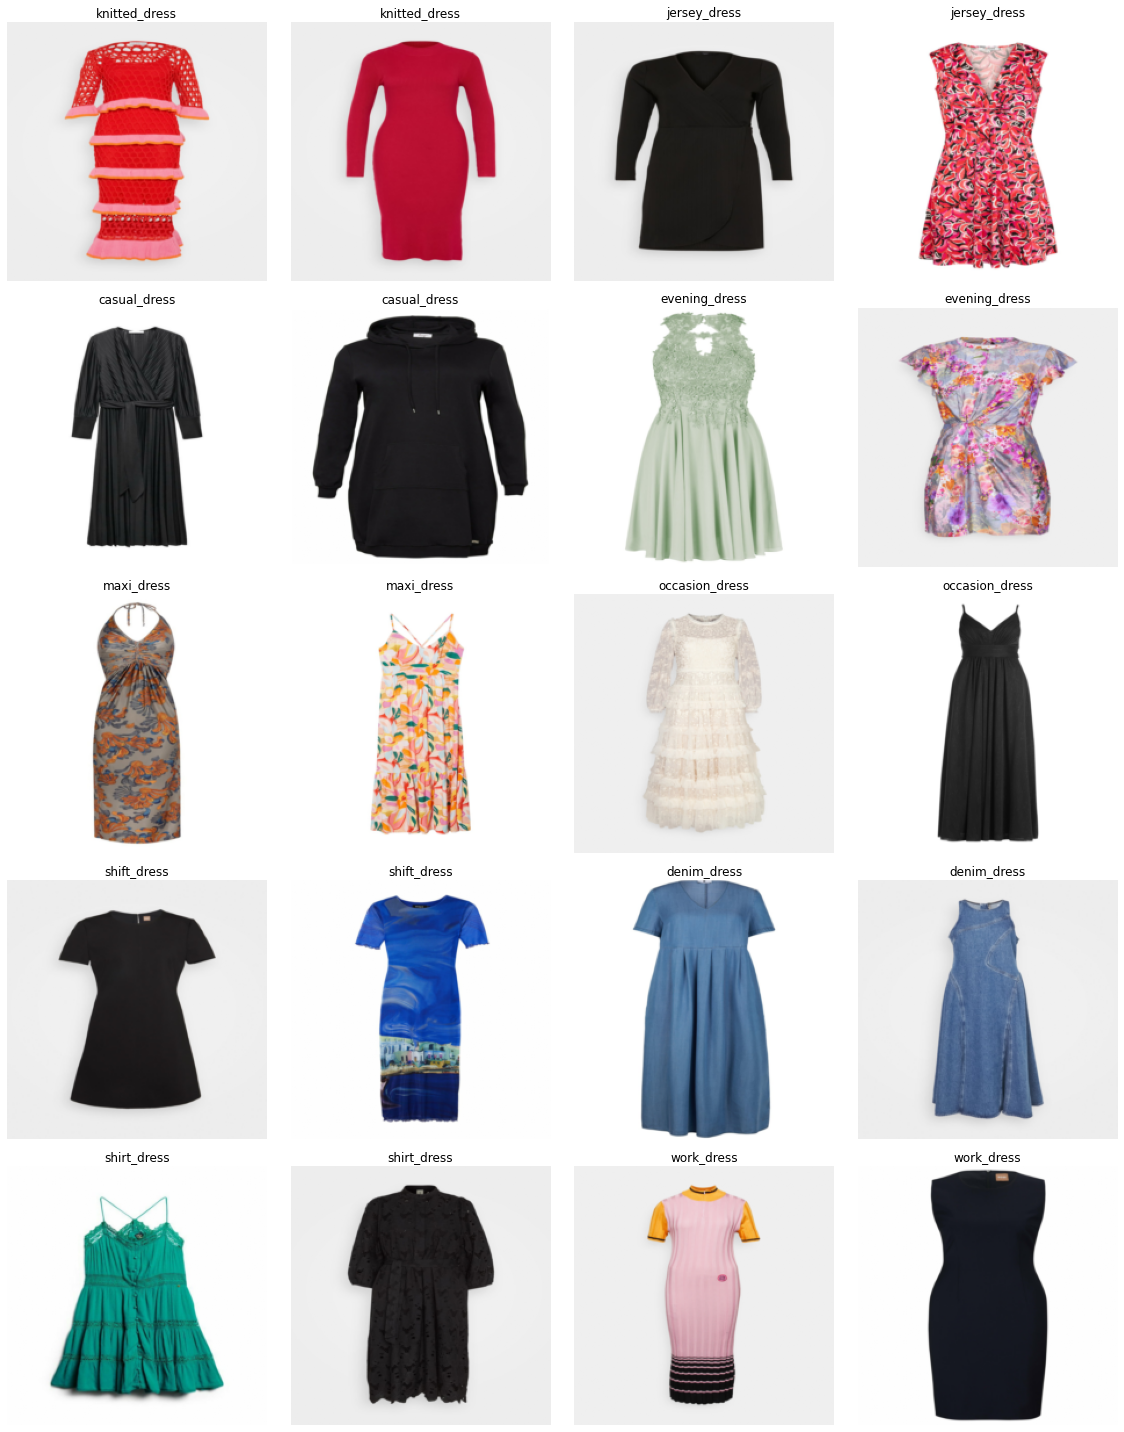

In [110]:
indices_per_label = defaultdict(list) #label integer --> dataset indices mapping
for idx in range(len(dataset)): 
    _, label_int = dataset[idx]
    indices_per_label[label_int].append(idx)

inv_label_map = {v: k for k, v in dataset.label_map.items()} #we need to map label integer back to string label for display

images_per_category = 2
num_categories = len(indices_per_label)
total_images = num_categories * images_per_category

#display grid
rows, cols = 5, 4
fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axs = axs.flatten()

img_idx = 0
for label, indices in indices_per_label.items():
    samples = random.sample(indices, min(images_per_category, len(indices)))
    for sample_idx in samples:
        image, label_int = dataset[sample_idx]
        img_np = image.permute(1, 2, 0).numpy()

        ax = axs[img_idx]
        ax.imshow(img_np)
        ax.set_title(inv_label_map[label_int])
        ax.axis('off')

        img_idx += 1

#hide remaining axis if images < grisd
for i in range(img_idx, len(axs)):
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [111]:
def analyze_dataset_biases(df, label_col='garment_types', attr_cols=None):
    print(f"Total samples: {len(df)}")
    print(f"Number of classes: {df[label_col].nunique()}")
    
    class_counts = df[label_col].value_counts()
    print("\nclass distribution:")
    print(class_counts)
    plt.figure(figsize=(10,4))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.xticks(rotation=45)
    plt.title('class distribution')
    plt.show()
    
    if attr_cols is None:
        attr_cols = [c for c in df.columns if c != label_col]
    
    for attr in attr_cols:
        print(f"\n{attr} top values:")
        print(df[attr].value_counts().head(10)) #top 10
    
    #plot distributions of top 3 attributes by number of unique values
    top_attrs = sorted(attr_cols, key=lambda c: df[c].nunique())[:3]
    for attr in top_attrs:
        plt.figure(figsize=(12,5))
        sns.countplot(data=df, x=attr, hue=label_col, order=df[attr].value_counts().index[:10])
        plt.xticks(rotation=45)
        plt.title(f'{attr} distribution by {label_col}')
        plt.show()
    
    #correlation with label
    def cramers_v(x, y):
        cm = pd.crosstab(x, y)
        chi2 = ss.chi2_contingency(cm)[0]
        n = cm.sum().sum()
        phi2 = chi2 / n
        r, k = cm.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    
    corr_vals = {}
    for attr in attr_cols:
        try:
            corr_vals[attr] = cramers_v(df[attr], df[label_col])
        except:
            print(f"Skipping {attr} due to error")
    
    corr_series = pd.Series(corr_vals).sort_values(ascending=False)
    print("\ncorrelation with tgt label")
    print(corr_series)
    
    plt.figure(figsize=(8,3))
    sns.barplot(x=corr_series.index, y=corr_series.values)
    plt.xticks(rotation=45)
    plt.title("correlation")
    plt.show()

Total samples: 10821
Number of classes: 10

class distribution:
garment_types
casual_dress      3783
knitted_dress     1642
evening_dress     1498
jersey_dress      1440
maxi_dress         992
occasion_dress     599
shift_dress        309
denim_dress        236
shirt_dress        163
work_dress         159
Name: count, dtype: int64


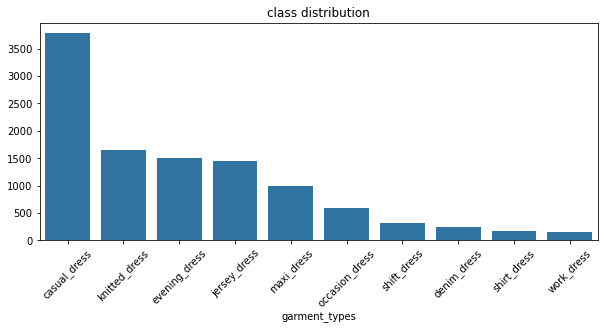


brand top values:
brand
Next           288
VILA           201
Vero Moda      199
Kaffe          160
Ulla Popken    156
Mango          155
ONLY           154
WAL G.         154
Esprit         150
Vera Mont      145
Name: count, dtype: int64

Fabric top values:
Fabric
Jersey     3021
Chiffon    1640
Missing    1629
Knit       1290
Satin       942
Rib         809
Denim       322
Lace        307
Tulle       279
Sweat       186
Name: count, dtype: int64

Pattern top values:
Pattern
Plain           5747
Print           1428
Floral          1326
Marl             747
Missing          463
Striped          365
Animal print     293
Polka dot        124
Checked           90
Colourful         81
Name: count, dtype: int64

Collar top values:
Collar
Standing collar     5748
Missing             3702
Turn-down collar     658
Polo neck            250
Other                153
Hood                 132
Ruffle collar        107
Lapel collar          71
Name: count, dtype: int64

Fastening top values:
Faste

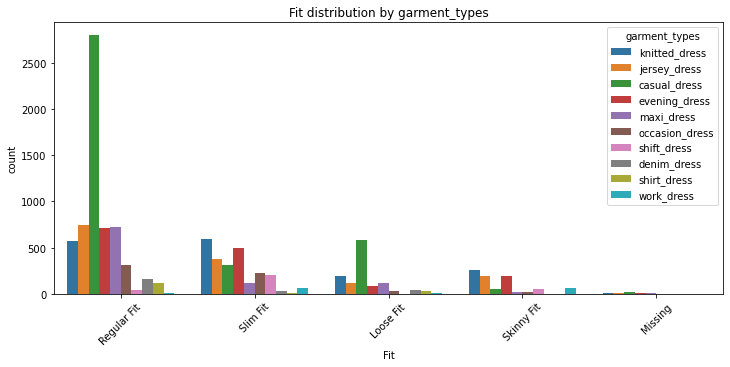

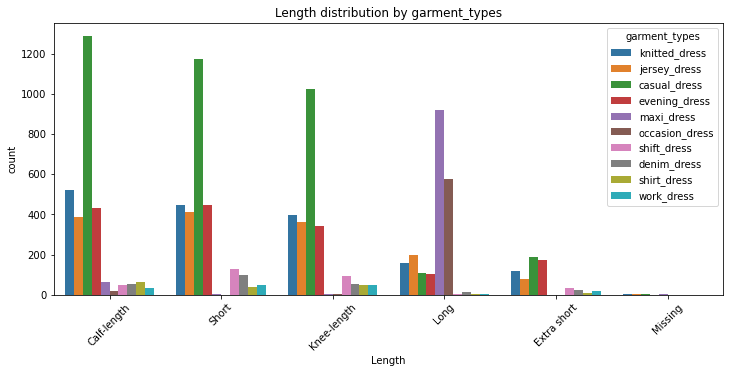

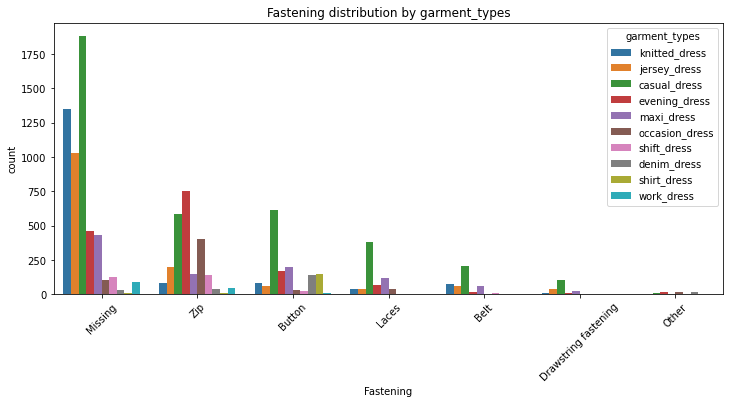


correlation with tgt label
Fabric       0.452087
Length       0.358931
brand        0.348205
Fastening    0.254312
Fit          0.240042
Pattern      0.220118
Collar       0.197497
Shape        0.181128
Neckline     0.179070
Color        0.138423
dtype: float64


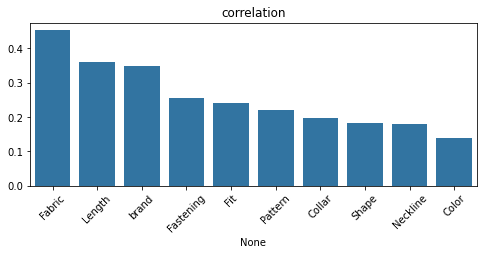

In [112]:
attr_columns = ['brand', 'Fabric', 'Pattern', 'Collar', 'Fastening', 'Neckline', 'Shape', 'Length', 'Fit', 'Color']
analyze_dataset_biases(train_df, label_col='garment_types', attr_cols=attr_columns)

- After exploring the dataset, I found that the no. of samples per dress category is quite imbalanced. For example, casual_dress has ~3,700 samples, while work_dress and shirt_dress have fewer than 200 each. This could cause the model to favor the more common classes which will affect implementations.
- Other attributes like Fastening and Collar have many missing values, which might affect model performance. The distributions of attributes like Brand, Fabric, and Pattern are also skewed. We have a bias here where certain brands or fabrics are overrepresented in specific dress categories.
- Fabric, Length and Brand seem to have a significant relationship with dress categories. This means that these features are likely important for classification and the model might rely on them (= other attributes contribute lesser).

### Pre-processing of Images

Implement this pre-processing sequence to your custom dataset:

1. Resize image to make its longest side 224 pixels (maintaining aspect ratio).
2. Apply the padding needed for the shorter side to make the image 224x224.
3. Ensure your final output images from this step are exactly 224x224 pixels.

In [113]:
class ResizeAndPad:
    def __init__(self, size=224, fill=0):
        self.size = size
        self.fill = fill

    def __call__(self, img):
        #step 1: Resize so the longest side is 224 (maintain aspect ratio)
        w, h = img.size
        scale = self.size / max(w, h)
        new_w, new_h = int(w * scale), int(h * scale)
        img = img.resize((new_w, new_h), Image.BILINEAR)

        #step 2: Pad the shorter side to make the image 224x224
        pad_w = self.size - new_w
        pad_h = self.size - new_h
        # padding(left, top, right, bottom)
        padding = (pad_w // 2, pad_h // 2, pad_w - pad_w // 2, pad_h - pad_h // 2)
        img = T.functional.pad(img, padding, fill=self.fill)

        #step 3: o/p should be exactly 224x224
        return img

transform = T.Compose([
    ResizeAndPad(224),
    T.ToTensor(),
])
dataset = ImageDressDataset(dataframe=train_df, img_dir='./images/raw', transform=transform)

In [114]:
rand_index = random.sample(range(len(dataset)), 5)

for i, idx in enumerate(rand_index):
    image, label = dataset[idx]
    print(f"random sample {i} (index {idx}): shape = {image.shape}")

random sample 0 (index 9863): shape = torch.Size([3, 224, 224])
random sample 1 (index 434): shape = torch.Size([3, 224, 224])
random sample 2 (index 9195): shape = torch.Size([3, 224, 224])
random sample 3 (index 3257): shape = torch.Size([3, 224, 224])
random sample 4 (index 10647): shape = torch.Size([3, 224, 224])


### Normalization: Standardizing Pixel Values

Implement this normalization to the custom dataset in PyTorch using torchvision.transforms. Normalize with the ImageNet mean and standard deviation values. Ensure this transform is applied after the image has been converted to a tensor and its pixel values scaled (e.g., to [0,1] by `transforms.ToTensor())`.

In [115]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

class ResizeAndPad:
    def __init__(self, size=224, fill=0):
        self.size = size
        self.fill = fill
    def __call__(self, img):
        w, h = img.size
        scale = self.size / max(w, h)
        new_w, new_h = int(w * scale), int(h * scale)
        img = img.resize((new_w, new_h), Image.BILINEAR)
        pad_w = self.size - new_w
        pad_h = self.size - new_h
        padding = (pad_w // 2, pad_h // 2, pad_w - pad_w // 2, pad_h - pad_h // 2)
        img = T.functional.pad(img, padding, fill=self.fill)
        return img

transform_image = T.Compose([
    ResizeAndPad(224),
    T.ToTensor(),
    T.Normalize(mean=imagenet_mean, std=imagenet_std)
])

dataset = ImageDressDataset(dataframe=train_df, img_dir='./images/raw', transform=transform_image)

Min pixel value in batch: -2.118
Max pixel value in batch: 2.640


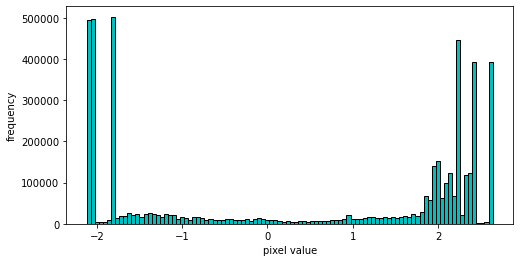

In [116]:
#let's check a batch of images
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
images, _ = next(iter(dataloader))  #the shape would be (batch_size, 3, 224, 224)
print(f"Min pixel value in batch: {images.min():.3f}")
print(f"Max pixel value in batch: {images.max():.3f}")

# flatten to 1d for histogram
pixels = images.flatten().numpy()
plt.figure(figsize=(8, 4))
plt.hist(pixels, bins=100, color='c', edgecolor='k')
plt.xlabel("pixel value")
plt.ylabel("frequency")
plt.show()

In the histogram for a general batch, there's tall spikes at the min and max ends of the range. This might be caused by black padding (all 0s before normalization) and some pure white pixels in the dress images. After normalization, these get pushed to the extreme ends. The other pixel values form a much lower (a bit bell shaped) curve in the middle after normalization. 

## Part II: Approach A - Classification with Preextracted DinoV2 Features

End goal: Identify the MLP model (specific architecture and hyper-parameters) that achieved the best performance on my validation set.

### Feature Extraction Using DinoV2

This code snippet demonstrates how to use the pre-trained DinoV2 model to extract features from an image. 

In [117]:
# from PIL import Image
# import torch
# import torchvision.transforms as T #torchvision.transforms provides common image transformations.

# # Load the pre-trained DinoV2 model
# dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
# # Set the device to GPU if available, otherwise use CPU
# device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
# dinov2_vits14.to(device)

# # Open an example image using PIL
# image = Image.open('Idea.png')

# # Define the transformations: convert to tensor, resize, and normalize
# transform_image = T.Compose([T.ToTensor(), T.Resize(224), T.Normalize([0.5], [0.5])])

# # disables gradient calculation, which reduces memory usage and speeds up computations since we are only performing inference.
# with torch.no_grad():
#   # Apply transformations to the image and move it to the appropriate device
#   image_tensor = transform_image(image).to(device)
#   # Extract features using the DinoV2 model
#   dino_embedding = dinov2_vits14(image_tensor.unsqueeze(0)) #image_tensor.unsqueeze(0) adds a batch dimension to the tensor, as the model expects a batch of images.

In [118]:
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
dinov2_vits14.to(device)
dinov2_vits14.eval()  #for inference

def extract_and_save_features(dataset, split_name, batch_size=32):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_features = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            #fw pass through DinoV2 to get feature vectors
            features = dinov2_vits14(images)  #o/p shape: [batch_size, feature_dim]
            
            #put the features and labels to CPU and convert to numpy
            all_features.append(features.cpu().numpy())
            all_labels.append(labels.numpy())

    #concatenate all batches into a single array
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    #save extracted features and labels as .npy files
    os.makedirs('./features', exist_ok=True)
    np.save(f'./features/{split_name}_features.npy', all_features)
    np.save(f'./features/{split_name}_labels.npy', all_labels)

    print(f"{split_name} features saved: {all_features.shape}, labels: {all_labels.shape}")

Using cache found in /home/lsivakumar/.cache/torch/hub/facebookresearch_dinov2_main


In [119]:
train_dataset = ImageDressDataset(dataframe=train_df, img_dir='./images/raw', transform=transform_image)
valid_dataset = ImageDressDataset(dataframe=valid_df, img_dir='./images/raw', transform=transform_image)
test_dataset = ImageDressDataset(dataframe=test_df, img_dir='./images/raw', transform=transform_image)

extract_and_save_features(train_dataset, 'train')
extract_and_save_features(valid_dataset, 'valid')
extract_and_save_features(test_dataset, 'test')

features = np.load('./features/train_features.npy')
print("DinoV2 feature dimensionality:", features.shape[1])  

train features saved: (10821, 384), labels: (10821,)
valid features saved: (2706, 384), labels: (2706,)
test features saved: (3382, 384), labels: (3382,)
DinoV2 feature dimensionality: 384


### Training and Hyper-parameters

1. Define your MLP model architecture using torch.nn.Module. Clearly state your initial choices for the number of hidden layers and neurons per layer (you will tune these later).
2. Experiment with core hyperparameters
3. Implement early stopping in your training loop. Explain your chosen
patience value and how you track the "best model" weights.
4. Introduce LR Scheduler to your best configuration so far.

In [120]:
#load
train_features = np.load('./features/train_features.npy')
train_labels = np.load('./features/train_labels.npy')
valid_features = np.load('./features/valid_features.npy')
valid_labels = np.load('./features/valid_labels.npy')
test_features = np.load('./features/test_features.npy')
test_labels = np.load('./features/test_labels.npy')

print(f"Train features shape: {train_features.shape}")
print(f"Valid features shape: {valid_features.shape}")
print(f"Test features shape: {test_features.shape}")

Train features shape: (10821, 384)
Valid features shape: (2706, 384)
Test features shape: (3382, 384)


#### 1. MLP Architecture

- Implemented the model to accept a list of `hidden_dims` instead of fixing the number and neurons.
- I added dropout layers to reduce overfitting, initially set it to 0.2.
- The final layer maps to the no.of garment classes, outputs raw logits which is convenient to feed into CrossEntropyLoss.

In [121]:
#MLP Definition
class DressesMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout=0.4):
        """
        flexible MLP with adjustablee hidden layers and dropout regularization.
        
        args:
            input_dim (int): dimension 384
            hidden_dims (list of int): list of hidden layer sizes for experiments (e.g., [256] or [512, 128])
            output_dim (int): no. of output classes
            dropout (float): dropout rate for regularization
        """
        super(DressesMLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

def load_data(split_name):  #load extracted features + labels 
    features = np.load(f'./features/{split_name}_features.npy')
    labels = np.load(f'./features/{split_name}_labels.npy')
    return features, labels


#### 2. Early Stopping

Implement early stopping in your training loop. Explain your chosen
patience value and how you track the "best model" weights.

**Solution**


Implemented early stopping by monitoring the validation loss during training. I choose initial patience value of 5 epochs--> if validation loss does not improve for 5 consecutive epochs, training stops early.  

To keep track of the best model, I save a copy of the model’s weights whenever the validation loss improves, so after training ends, I can restore the model with the lowest validation loss.

In [122]:
class EarlyStopping: #we will use this inside the training loop
    def __init__(self, patience=5, verbose=False):
        """
        args:
            patience (int): #of epochs to wait after last improvement.
            verbose (bool): if True, prints messages.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = np.Inf
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            if self.verbose:
                print(f'validation loss improved ({self.best_loss:.4f} --> {val_loss:.4f}). Saving model...')
            self.best_loss = val_loss
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f'no improvement in validation loss for {self.counter} epochs.')
            if self.counter >= self.patience:
                if self.verbose:
                    print('Early stopping triggered.')
                self.early_stop = True

#### Training Loop

Tuned core hyperparameters here and include early stopping and LR Scheduler.

In [123]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=50, patience=7):
    """
this function returns
        model: the best model (with lowest val loss)
        history: dictionary with train/val loss and accuracy per epoch
    """
    model.to(device)
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
#_______________________________Training_____________________________________________________
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1}/{epochs}')
        model.train()   
        running_loss = 0
        all_preds = []
        all_labels = []

        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x_batch.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = accuracy_score(np.concatenate(all_labels), np.concatenate(all_preds))
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

#_______________________________Validation_____________________________________________________
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                outputs = model(x_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item() * x_val.size(0)
                preds = torch.argmax(outputs, dim=1)
                val_preds.append(preds.cpu().numpy())
                val_labels.append(y_val.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(np.concatenate(val_labels), np.concatenate(val_preds))
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

        #step the scheduler based on validation loss
        if scheduler is not None:
            scheduler.step(val_loss)

#_______________________________Early stopping_____________________________________________________
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f'Stopping early at epoch {epoch+1}')
            break

        for param_group in optimizer.param_groups:           # print current learning rate
            print(f'Current LR: {param_group["lr"]}')

    #load best model weights
    model.load_state_dict(early_stopping.best_model_wts)
    return model, history

In [124]:
# features_dir = './features/'
# files = os.listdir(features_dir)
# for f in files:
#     print(f)

#### Experiment Loop


The function `run_experiments` finds the best settings for training an MLP classifier on features extracted from DinoV2. The steps it follows are:

1. load the training and validation data (features and labels) for training.
2. we try various combinations of batch sizes, learning rates, and MLP architectures ask given in the question (single hidden layer(256 units) vs two-layer network (512 and 128 units) + batch sizes (64 and 128) + learning rates (0.01, 0.005, 0.001).
3. for each combination, it trains the model using early stopping (patience = 7 epochs) and adjusts the learning rate automatically (LR Scheduler: ReduceLROnPlateau) if the validation loss stops improving. It records the best validation accuracy and how long training took for each run.
4. after all runs, summarized results and print the top 5 best performing setups.
5. create plots to compare how different learning rates and architectures affected validation accuracy, and shows training and validation loss and accuracy curves for the last experiment.

Using device: cuda
no. of classes: 10

Training with batch_size=64, hidden_layers=[256], lr=0.01

Epoch 1/50
Train Loss: 1.7089 | Train Acc: 0.4403 | Val Loss: 2.3766 | Val Acc: 0.3574
validation loss improved (inf --> 2.3766). Saving model...
Current LR: 0.01

Epoch 2/50
Train Loss: 1.4604 | Train Acc: 0.4822 | Val Loss: 2.5866 | Val Acc: 0.3551
no improvement in validation loss for 1 epochs.
Current LR: 0.01

Epoch 3/50
Train Loss: 1.4368 | Train Acc: 0.4924 | Val Loss: 2.5122 | Val Acc: 0.3529
no improvement in validation loss for 2 epochs.
Current LR: 0.01

Epoch 4/50
Train Loss: 1.4283 | Train Acc: 0.4966 | Val Loss: 2.5548 | Val Acc: 0.3533
no improvement in validation loss for 3 epochs.
Early stopping triggered.
Stopping early at epoch 4
Best val accuracy: 0.3574, Training time: 0.8s
Saved checkpoint: ./checkpoints/model_bs64_hidden256_lr0.01.pth

Training with batch_size=64, hidden_layers=[256], lr=0.005

Epoch 1/50
Train Loss: 1.4230 | Train Acc: 0.5023 | Val Loss: 2.4258 | Va

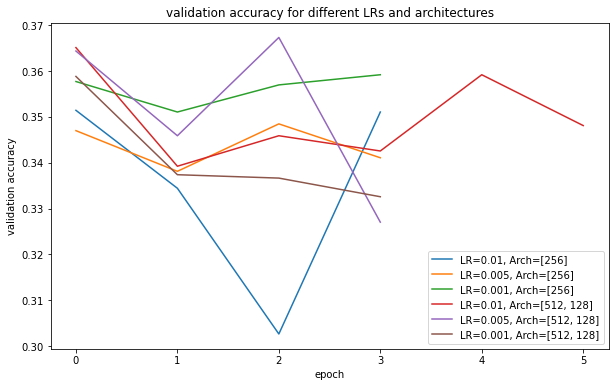

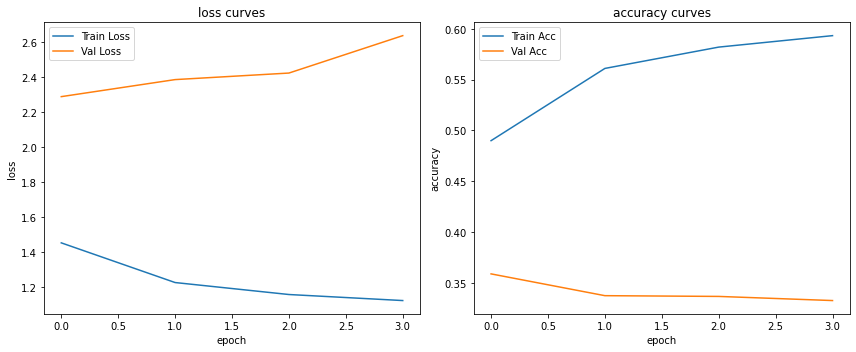

In [199]:
def run_experiments():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    input_dim = 384  
    train_features, train_labels = load_data('train')
    val_features, val_labels = load_data('valid')

    num_classes = len(np.unique(train_labels))
    print(f'no. of classes: {num_classes}')

    train_features = torch.tensor(train_features, dtype=torch.float32)  #convert to tensors
    train_labels = torch.tensor(train_labels, dtype=torch.long)
    val_features = torch.tensor(val_features, dtype=torch.float32)
    val_labels = torch.tensor(val_labels, dtype=torch.long)

    learning_rates = [1e-2, 5e-3, 1e-3]  # trying some LR ranges
    hidden_layer_options = [[256], [512, 128]]  # start simple, gets more complex
    batch_sizes = [64, 128]
    epochs = 50
    patience = 3  # <-- Reduced early stopping patience

    results = []
    histories = {}  # to store histories keyed by (hidden_dims, lr)

    # Directory to save checkpoints
    checkpoint_dir = './checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)

    for batch_size in batch_sizes:
        train_dataset = TensorDataset(train_features, train_labels)
        val_dataset = TensorDataset(val_features, val_labels)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        for hidden_dims in hidden_layer_options:
            for lr in learning_rates:
                print(f'\nTraining with batch_size={batch_size}, hidden_layers={hidden_dims}, lr={lr}')
                model = DressesMLP(input_dim, hidden_dims, num_classes, dropout=0.4).to(device)
                criterion = torch.nn.CrossEntropyLoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # add weight_decay
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

                start_time = time.time()
                model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs, patience)
                elapsed = time.time() - start_time

                best_val_acc = max(history['val_acc'])
                print(f'Best val accuracy: {best_val_acc:.4f}, Training time: {elapsed:.1f}s')

                # Save checkpoint for this run
                checkpoint_name = f'model_bs{batch_size}_hidden{"-".join(map(str, hidden_dims))}_lr{lr}.pth'
                checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
                torch.save(model.state_dict(), checkpoint_path)
                print(f"Saved checkpoint: {checkpoint_path}")

                results.append({
                    'batch_size': batch_size,
                    'hidden_layers': hidden_dims,
                    'learning_rate': lr,
                    'best_val_acc': best_val_acc,
                    'train_time_sec': elapsed,
                    'checkpoint_path': checkpoint_path
                })

                histories[(tuple(hidden_dims), lr)] = history

    results_df = pd.DataFrame(results)

    summary_df = results_df.sort_values(by='best_val_acc', ascending=False).reset_index(drop=True)
    print("\nSummary of experiments (top 5):")
    print(summary_df.head(5).to_string(index=False))

    best_row = summary_df.iloc[0]
    print("\nFinal chosen hyperparameters:")
    print(best_row.to_string())
    print('\nAll experiments completed.')

    plt.figure(figsize=(10,6))
    for hidden_dims in hidden_layer_options:
        for lr in learning_rates:
            key = (tuple(hidden_dims), lr)
            if key in histories:
                plt.plot(histories[key]['val_acc'], label=f'LR={lr}, Arch={hidden_dims}')
    plt.xlabel('epoch')
    plt.ylabel('validation accuracy')
    plt.title('validation accuracy for different LRs and architectures')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('loss curves')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('accuracy curves')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    run_experiments()

### Report on MLP Classification Experiments Using DinoV2 Features

- After running these experiments, the best validation accuracy I achieved was around 38.5%, using a [512, 128] architecture, batch size 64, and learning rate 0.01. This accuracy is reasonable given that I’m using frozen DINOv2 features—without fine-tuning, the model is limited to learning just a classifier on top and can’t adapt to dataset-specific patterns.
- The dataset’s class imbalance and attribute biases (noted earlier) likely make generalization harder. This is reflected in the gap between training accuracy and validation accuracy.
- I experimented with weighted CrossEntropyLoss to address imbalance by emphasizing minority classes, but it actually reduced validation accuracy to about 29%, so I reverted to the standard loss.
- Smaller learning rates like 0.001 worked better for simpler architectures such as [256], while 0.01 was optimal for deeper models. Increasing batch size to 128 also yielded comparable results (~36.8%) with the [256] architecture.
- To combat overfitting, I increased dropout from 0.2 to 0.4 and added weight decay (L2 regularization) with a value of 1e-4. These changes slightly improved validation accuracy. Early stopping with a patience of 3 epochs also helped.
- Training loss steadily decreased, but validation loss began rising after a few epochs, indicating overfitting.

Overall, this is likely close to the best performance achievable with this setup and serves as a solid baseline before moving on to fine-tuning.

## Part III: Approach B - Fine-tuning an ImageNet Pre-trained CNN

End goal: Select the corresponding CNN model (with its specific hyper-parameters) that achieved the best performance on my validation set.

### Model Selection

1. Choose one pre-trained CNN model from torchvision.models (e.g.,resnet18).
2. Justify your choice: consider factors like the expected trade-off between model complexity (number of parameters), computational resources required for training (GPU memory, time), and potential classification performance.
3. Load your chosen model to get the ImageNet pre-trained weights.

###### **Choice**

- For fine-tuning on our dress classification dataset with 10k+ images across 10 classes, I choose ResNet18.
- ResNet18 strikes a good balance between model complexity, training speed, and expected performance for this dataset size. It has around 11 million parameters, which is much smaller (half the size almost) than deeper models. This smaller size means it requires less GPU memory and trains faster.
- While deeper models like ResNet50 might achieve higher accuracy on very large datasets, ResNet18 is still powerful enough to learn useful visual features and adapt well to our task. It also has residual connections help the network train effectively without encountering problems like vanishing gradients.

In [145]:
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

### Adapting the Classifier Head (The Final Layer):

1. Inspect the architecture of your chosen pre-trained model (e.g., by printing model).
2. Identify the name and characteristics (especially in_features) of its final classification layer.
3. Replace this layer with a new torch.nn.Linear layer that has the correct number of out_features for your dress categories.

In [146]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

The final architecture is `(fc): Linear(in_features=512, out_features=1000, bias=True)`. Input features to this layer `(in_features)` is 512 and output features `(out_features)` is 1000 which corresponds to the 1000 ImageNet classes.

In [147]:
num_classes = 10  # dress classes

#replace the final fc layer
model.fc = nn.Linear(in_features=512, out_features=num_classes)
print(model.fc)

Linear(in_features=512, out_features=10, bias=True)


### Fine-tuning the Entire Network (Full Fine-tuning)

**Training:**
1. Implement a training and validation loop similar to previous section, but now your model takes batches of pre-processed images as input, not dinoV2 feature vectors.
2. Use an appropriate loss function (e.g., CrossEntropyLoss) and optimizer.
3. Employ early stopping based on validation performance.
4. For hyperparameter tuning primarily focus on:
    - Learning Rate: Start with your chosen optimizer (e.g., Adam) and a common batch size (e.g., 32). 
    - Experiment systematically with different learning rates (e.g., 5e-4, 1e-4, 5e-5, 1e-5). 
    - Plot validation accuracy/loss curves for these LR trials.
5. Learning Rate Scheduler: Once you have a good constant LR, apply one LR scheduler(e.g., ReduceLROnPlateauor, CosineAnnealingLR) to see if it improves convergence or final performance. Compare validation curves.
6. Report your final chosen hyper-parameters (LR, optimizer, batch size, scheduler). Justify your choices with key plots (especially LR comparison and scheduler impact) and a summary of your findings.

In [129]:
torch.save(model.state_dict(), 'model_checkpoint.pth')

####  Model Training with Early Stopping and Weighted Sampling

This function implements the core training and validation loop for fine-tuning the model. It uses mixed precision for efficiency and applies a weighted random sampler to address class imbalance during training. Early stopping based on validation accuracy is included to prevent overfitting. The function tracks and returns training and validation loss and accuracy for each epoch.

In [130]:
model.load_state_dict(torch.load('model_checkpoint.pth'))

<All keys matched successfully>

In [162]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True #deterministic
    torch.backends.cudnn.benchmark = False

def get_weighted_sampler(df, label_col='label'):
    counts = Counter(df[label_col])
    class_weights = {cls: 1.0/count for cls, count in counts.items()}
    weights = [class_weights[label] for label in df[label_col]]
    sampler = torch.utils.data.WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    return sampler

def train_finetune_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=30, patience=5, seed=42):
    set_seed(seed)  #set seed for reproducibility

    model.to(device)
    scaler = GradScaler()  # mixed precision training
    best_val_acc = 0.0
    best_model_wts = None
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    epochs_no_improve = 0

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for inputs, labels in tqdm(train_loader, desc='Training', leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            total_samples += inputs.size(0)

        epoch_train_loss = running_loss / total_samples
        epoch_train_acc = running_corrects / total_samples

        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_samples = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc='Validation', leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.amp.autocast(device_type='cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data).item()
                val_samples += inputs.size(0)

        epoch_val_loss = val_loss / val_samples
        epoch_val_acc = val_corrects / val_samples

        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(epoch_val_loss)
        else:
            scheduler.step()

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f} | LR: {current_lr:.6f}")

        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"early stopping triggered after {epoch+1} epochs.")
                break

    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    return model, history

#### Hyperparameter Tuning

- I created weighted sampling for the training loader to handle class imbalance. In Part II, it didn't yield me better results, but in this case, it did.
- For hyperparameter tuning, I systematically trained the model with different learning rates and a batch size of 32, as the task required. I used a learning rate scheduler (ReduceLROnPlateau) to adjust the learning rate based on validation loss.
- During training, I implemented early stopping based on validation accuracy with patience=5.
- Phase 1: I compare validation accuracies with LR sweep and plotted the curves to visually analyze which LR worked best.
- Phase 2: Retrained the final model using the best learning rate (1e-4) and `ReduceLROnPlateau` LR scheduler, early stopping, and plotted the final training and validation loss and accuracy curves.

In [156]:
label_map_inv = {v: k for k, v in label_map.items()}  # int label -> garment type

val_label_counts = val_df['label'].value_counts()

for label_int, count in val_label_counts.items():
    print(f"{label_map_inv[label_int]}: {count} samples")

shirt_dress: 1189 samples
casual_dress: 497 samples
evening_dress: 467 samples
knitted_dress: 453 samples
jersey_dress: 316 samples
shift_dress: 186 samples
maxi_dress: 99 samples
occasion_dress: 72 samples
work_dress: 53 samples
denim_dress: 50 samples


Validation set is imbalanced like the training set with majority classes like shirt_dress and casual_dress having many more samples than minority classes such as work_dress and denim_dress. This will definitely affect model generalization and per-class accuracy during fine-tuning.

In [163]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def run_finetuning_experiments(train_df, val_df, num_classes=10, device=None, seed=42):
    set_seed(seed)  

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    if 'label' not in train_df.columns:  # remap garment_types
        unique_labels = train_df['garment_types'].unique()
        label_map = {label: idx for idx, label in enumerate(unique_labels)}
        train_df['label'] = train_df['garment_types'].map(label_map)
        val_df['label'] = val_df['garment_types'].map(label_map)

    batch_size = 32
    epochs = 15
    patience = 5
    learning_rates = [5e-4, 1e-4, 5e-5, 1e-5]

    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]

    train_transform = T.Compose([
        ResizeAndPad(224),
        T.RandomHorizontalFlip(),
        T.ColorJitter(0.2, 0.2, 0.2, 0.1),
        T.ToTensor(),
        T.Normalize(imagenet_mean, imagenet_std)
    ])

    val_transform = T.Compose([
        ResizeAndPad(224),
        T.ToTensor(),
        T.Normalize(imagenet_mean, imagenet_std)
    ])

    train_dataset = ImageDressDataset(train_df, './images/raw', train_transform)
    val_dataset = ImageDressDataset(val_df, './images/raw', val_transform)
    train_sampler = get_weighted_sampler(train_df, label_col='label')

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    base_model = resnet18(weights=ResNet18_Weights.DEFAULT)
    base_model.fc = nn.Linear(512, num_classes)  # just to reconfirm

    criterion = nn.CrossEntropyLoss()

    results = []
    histories = {}

    for lr in learning_rates:
        print(f"\nTraining with learning rate: {lr}")
        set_seed(seed)  # Reset seed before each run for reproducibility
        model = copy.deepcopy(base_model).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

        start = time.time()
        model, history = train_finetune_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs, patience, seed=seed)
        elapsed = time.time() - start

        best_val_acc = max(history['val_acc'])
        print(f"Best val accuracy: {best_val_acc:.4f}, Training time: {elapsed:.1f}s")

        results.append({
            'learning_rate': lr,
            'best_val_acc': best_val_acc,
            'train_time_sec': elapsed
        })
        histories[lr] = history

    results_df = pd.DataFrame(results).sort_values(by='best_val_acc', ascending=False).reset_index(drop=True)
    print("\nSummary of learning rate experiments:")
    print(results_df)

    best_lr = results_df.iloc[0]['learning_rate']
    print(f"\nBest learning rate selected: {best_lr}")

    plt.figure(figsize=(10, 6))
    for lr in learning_rates:
        if lr in histories:
            plt.plot(histories[lr]['val_acc'], label=f'LR={lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy for Different Learning Rates')
    plt.legend()
    plt.show()

    print(f"\nTraining final model with best LR={best_lr} and LR scheduler...")

    final_model = copy.deepcopy(base_model).to(device)
    final_optimizer = optim.Adam(final_model.parameters(), lr=best_lr, weight_decay=1e-4)
    final_scheduler = optim.lr_scheduler.ReduceLROnPlateau(final_optimizer, mode='min', factor=0.5, patience=3)

    final_model, final_history = train_finetune_model(final_model, train_loader, val_loader, criterion, final_optimizer, final_scheduler, device, epochs, patience, seed=seed)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(final_history['train_loss'], label='Train Loss')
    plt.plot(final_history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(final_history['train_acc'], label='Train Accuracy')
    plt.plot(final_history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("\nFinal hyperparameters:")
    print(f"Learning Rate: {best_lr}")
    print(f"Batch Size: {batch_size}")
    print(f"Optimizer: Adam with weight_decay=1e-4")
    print(f"Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")
    print(f"Early Stopping Patience: {patience}")

    return final_model, final_history, results_df

/tmp/ipykernel_73191/3222729884.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # mixed precision training


Using device: cuda

Training with learning rate: 0.0005
Epoch 1/15


Train Loss: 1.3947 Acc: 0.5111 | Val Loss: 2.8068 Acc: 0.1973 | LR: 0.000500
Epoch 2/15


Train Loss: 1.0072 Acc: 0.6490 | Val Loss: 2.8874 Acc: 0.2465 | LR: 0.000500
Epoch 3/15


Train Loss: 0.8186 Acc: 0.7083 | Val Loss: 3.0079 Acc: 0.2365 | LR: 0.000500
Epoch 4/15


Train Loss: 0.7188 Acc: 0.7490 | Val Loss: 2.9015 Acc: 0.3241 | LR: 0.000500
Epoch 5/15


Train Loss: 0.6077 Acc: 0.7879 | Val Loss: 3.5662 Acc: 0.2520 | LR: 0.000250
Epoch 6/15


Train Loss: 0.4285 Acc: 0.8528 | Val Loss: 3.7307 Acc: 0.2749 | LR: 0.000250
Epoch 7/15


Train Loss: 0.3533 Acc: 0.8796 | Val Loss: 3.8588 Acc: 0.2967 | LR: 0.000250
Epoch 8/15


Train Loss: 0.3148 Acc: 0.8942 | Val Loss: 4.0375 Acc: 0.2439 | LR: 0.000250
Epoch 9/15


Train Loss: 0.2769 Acc: 0.9044 | Val Loss: 3.9414 Acc: 0.3093 | LR: 0.000125
early stopping triggered after 9 epochs.
Best val accuracy: 0.3241, Training time: 1880.8s

Training with learning rate: 0.0001
Epoch 1/15


Train Loss: 1.2296 Acc: 0.5745 | Val Loss: 2.9429 Acc: 0.2214 | LR: 0.000100
Epoch 2/15


Train Loss: 0.7403 Acc: 0.7514 | Val Loss: 3.0592 Acc: 0.2387 | LR: 0.000100
Epoch 3/15


Train Loss: 0.5674 Acc: 0.8053 | Val Loss: 3.3441 Acc: 0.2254 | LR: 0.000100
Epoch 4/15


Train Loss: 0.4815 Acc: 0.8348 | Val Loss: 3.1426 Acc: 0.3186 | LR: 0.000100
Epoch 5/15


Train Loss: 0.3881 Acc: 0.8696 | Val Loss: 3.7251 Acc: 0.2465 | LR: 0.000050
Epoch 6/15


Train Loss: 0.2664 Acc: 0.9138 | Val Loss: 3.6643 Acc: 0.3086 | LR: 0.000050
Epoch 7/15


Train Loss: 0.2112 Acc: 0.9345 | Val Loss: 3.7392 Acc: 0.3200 | LR: 0.000050
Epoch 8/15


Train Loss: 0.1721 Acc: 0.9478 | Val Loss: 3.9561 Acc: 0.3252 | LR: 0.000050
Epoch 9/15


Train Loss: 0.1460 Acc: 0.9546 | Val Loss: 4.1544 Acc: 0.2960 | LR: 0.000025
Epoch 10/15


Train Loss: 0.1034 Acc: 0.9694 | Val Loss: 4.1157 Acc: 0.3319 | LR: 0.000025
Epoch 11/15


Train Loss: 0.0884 Acc: 0.9757 | Val Loss: 4.2116 Acc: 0.3452 | LR: 0.000025
Epoch 12/15


Train Loss: 0.0737 Acc: 0.9795 | Val Loss: 4.2265 Acc: 0.3348 | LR: 0.000025
Epoch 13/15


Train Loss: 0.0656 Acc: 0.9830 | Val Loss: 4.2743 Acc: 0.3441 | LR: 0.000013
Epoch 14/15


Train Loss: 0.0521 Acc: 0.9867 | Val Loss: 4.3022 Acc: 0.3448 | LR: 0.000013
Epoch 15/15


Train Loss: 0.0494 Acc: 0.9870 | Val Loss: 4.2881 Acc: 0.3511 | LR: 0.000013
Best val accuracy: 0.3511, Training time: 3117.9s

Training with learning rate: 5e-05
Epoch 1/15


Train Loss: 1.3478 Acc: 0.5381 | Val Loss: 2.7566 Acc: 0.2040 | LR: 0.000050
Epoch 2/15


Train Loss: 0.8197 Acc: 0.7289 | Val Loss: 2.8282 Acc: 0.2262 | LR: 0.000050
Epoch 3/15


Train Loss: 0.6070 Acc: 0.8004 | Val Loss: 3.1021 Acc: 0.2446 | LR: 0.000050
Epoch 4/15


Train Loss: 0.4963 Acc: 0.8375 | Val Loss: 3.0820 Acc: 0.2901 | LR: 0.000050
Epoch 5/15


Train Loss: 0.4011 Acc: 0.8697 | Val Loss: 3.3447 Acc: 0.2735 | LR: 0.000025
Epoch 6/15


Train Loss: 0.3029 Acc: 0.9032 | Val Loss: 3.4427 Acc: 0.2846 | LR: 0.000025
Epoch 7/15


Train Loss: 0.2516 Acc: 0.9244 | Val Loss: 3.4242 Acc: 0.3001 | LR: 0.000025
Epoch 8/15


Train Loss: 0.2133 Acc: 0.9376 | Val Loss: 3.5284 Acc: 0.3001 | LR: 0.000025
Epoch 9/15


Train Loss: 0.1808 Acc: 0.9471 | Val Loss: 3.7228 Acc: 0.2923 | LR: 0.000013
Epoch 10/15


Train Loss: 0.1446 Acc: 0.9586 | Val Loss: 3.8223 Acc: 0.3163 | LR: 0.000013
Epoch 11/15


Train Loss: 0.1303 Acc: 0.9649 | Val Loss: 3.8083 Acc: 0.3215 | LR: 0.000013
Epoch 12/15


Train Loss: 0.1165 Acc: 0.9689 | Val Loss: 3.7680 Acc: 0.3271 | LR: 0.000013
Epoch 13/15


Train Loss: 0.1024 Acc: 0.9747 | Val Loss: 3.8088 Acc: 0.3300 | LR: 0.000006
Epoch 14/15


Train Loss: 0.0925 Acc: 0.9776 | Val Loss: 3.8949 Acc: 0.3230 | LR: 0.000006
Epoch 15/15


Train Loss: 0.0926 Acc: 0.9762 | Val Loss: 3.8659 Acc: 0.3256 | LR: 0.000006
Best val accuracy: 0.3300, Training time: 3074.0s

Training with learning rate: 1e-05
Epoch 1/15


Train Loss: 1.8193 Acc: 0.3722 | Val Loss: 2.3982 Acc: 0.1622 | LR: 0.000010
Epoch 2/15


Train Loss: 1.3640 Acc: 0.5481 | Val Loss: 2.5090 Acc: 0.1803 | LR: 0.000010
Epoch 3/15


Train Loss: 1.1374 Acc: 0.6310 | Val Loss: 2.6633 Acc: 0.1870 | LR: 0.000010
Epoch 4/15


Train Loss: 0.9986 Acc: 0.6797 | Val Loss: 2.6271 Acc: 0.2376 | LR: 0.000010
Epoch 5/15


Train Loss: 0.8795 Acc: 0.7194 | Val Loss: 2.7051 Acc: 0.2247 | LR: 0.000005
Epoch 6/15


Train Loss: 0.8009 Acc: 0.7412 | Val Loss: 2.7680 Acc: 0.2336 | LR: 0.000005
Epoch 7/15


Train Loss: 0.7531 Acc: 0.7613 | Val Loss: 2.7465 Acc: 0.2339 | LR: 0.000005
Epoch 8/15


Train Loss: 0.7030 Acc: 0.7836 | Val Loss: 2.7686 Acc: 0.2476 | LR: 0.000005
Epoch 9/15


Train Loss: 0.6612 Acc: 0.7936 | Val Loss: 2.7891 Acc: 0.2446 | LR: 0.000003
Epoch 10/15


Train Loss: 0.6403 Acc: 0.7951 | Val Loss: 2.7892 Acc: 0.2565 | LR: 0.000003
Epoch 11/15


Train Loss: 0.6163 Acc: 0.8106 | Val Loss: 2.8570 Acc: 0.2450 | LR: 0.000003
Epoch 12/15


Train Loss: 0.6036 Acc: 0.8115 | Val Loss: 2.8566 Acc: 0.2406 | LR: 0.000003
Epoch 13/15


Train Loss: 0.5865 Acc: 0.8159 | Val Loss: 2.7947 Acc: 0.2572 | LR: 0.000001
Epoch 14/15


Train Loss: 0.5663 Acc: 0.8230 | Val Loss: 2.8475 Acc: 0.2498 | LR: 0.000001
Epoch 15/15


Train Loss: 0.5734 Acc: 0.8240 | Val Loss: 2.8259 Acc: 0.2587 | LR: 0.000001
Best val accuracy: 0.2587, Training time: 3123.3s

Summary of learning rate experiments:
   learning_rate  best_val_acc  train_time_sec
0        0.00010      0.351072     3117.852200
1        0.00005      0.330007     3074.019082
2        0.00050      0.324095     1880.803737
3        0.00001      0.258684     3123.295338

Best learning rate selected: 0.0001


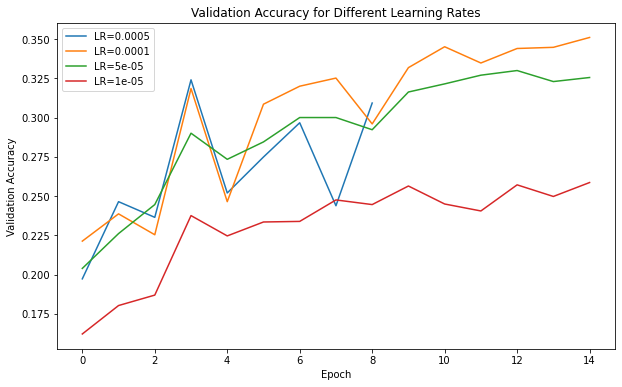

/tmp/ipykernel_73191/3222729884.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # mixed precision training



Training final model with best LR=0.0001 and LR scheduler...
Epoch 1/15


Train Loss: 1.2296 Acc: 0.5745 | Val Loss: 2.9429 Acc: 0.2214 | LR: 0.000100
Epoch 2/15


Train Loss: 0.7403 Acc: 0.7514 | Val Loss: 3.0592 Acc: 0.2387 | LR: 0.000100
Epoch 3/15


Train Loss: 0.5674 Acc: 0.8053 | Val Loss: 3.3441 Acc: 0.2254 | LR: 0.000100
Epoch 4/15


Train Loss: 0.4815 Acc: 0.8348 | Val Loss: 3.1426 Acc: 0.3186 | LR: 0.000100
Epoch 5/15


Train Loss: 0.3881 Acc: 0.8696 | Val Loss: 3.7251 Acc: 0.2465 | LR: 0.000050
Epoch 6/15


Train Loss: 0.2664 Acc: 0.9138 | Val Loss: 3.6643 Acc: 0.3086 | LR: 0.000050
Epoch 7/15


Train Loss: 0.2112 Acc: 0.9345 | Val Loss: 3.7392 Acc: 0.3200 | LR: 0.000050
Epoch 8/15


Train Loss: 0.1721 Acc: 0.9478 | Val Loss: 3.9561 Acc: 0.3252 | LR: 0.000050
Epoch 9/15


Train Loss: 0.1460 Acc: 0.9546 | Val Loss: 4.1544 Acc: 0.2960 | LR: 0.000025
Epoch 10/15


Train Loss: 0.1034 Acc: 0.9694 | Val Loss: 4.1157 Acc: 0.3319 | LR: 0.000025
Epoch 11/15


Train Loss: 0.0884 Acc: 0.9757 | Val Loss: 4.2116 Acc: 0.3452 | LR: 0.000025
Epoch 12/15


Train Loss: 0.0737 Acc: 0.9795 | Val Loss: 4.2265 Acc: 0.3348 | LR: 0.000025
Epoch 13/15


Train Loss: 0.0656 Acc: 0.9830 | Val Loss: 4.2743 Acc: 0.3441 | LR: 0.000013
Epoch 14/15


Train Loss: 0.0521 Acc: 0.9867 | Val Loss: 4.3022 Acc: 0.3448 | LR: 0.000013
Epoch 15/15


Train Loss: 0.0494 Acc: 0.9870 | Val Loss: 4.2881 Acc: 0.3511 | LR: 0.000013


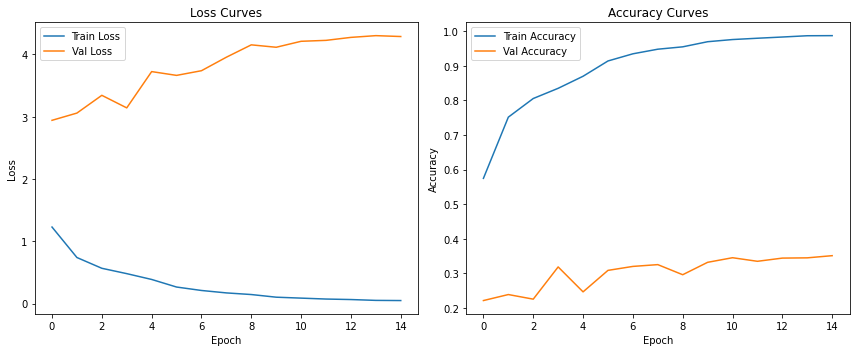


Final hyperparameters:
Learning Rate: 0.0001
Batch Size: 32
Optimizer: Adam with weight_decay=1e-4
Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)
Early Stopping Patience: 5


In [164]:
num_classes = len(train_df['garment_types'].unique())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

final_model, final_history, results_df = run_finetuning_experiments(train_df, valid_df, num_classes, device)

### Report on Experiments with fine-tuned DinoV2 Features

1. Plot: Validation accuracy for different learning rates :
       - At LR of 0.0005, the model started with a training accuracy of about 51% and validation accuracy around 20%. The training accuracy steadily improved, reaching over 90% by epoch 9, but validation accuracy fluctuated and peaked at about 32%. Early stopping was triggered at epoch 9 due to no improvement in validation accuracy.
   - With a learning rate of 0.0001, the model showed more stable improvements. Training accuracy increased from 57% to nearly 99% by epoch 15, and validation accuracy peaked at about 35%. This was the best performing learning rate in the sweep.
   - Lower learning rates (0.00005 and 0.00001) resulted in slower training and lower validation accuracy, with the smallest LR performing the worst.

Overall, the learning rate of **0.0001** provided the best balance between training speed and validation performance. The early stopping helped prevent overfitting.

2. I chose ReduceLROnPlateau because the validation loss in this imbalanced classification task can plateau unpredictably, so dynamically lowering the learning rate helps the model escape stagnation and improve generalization.
3. Using Adam with weight decay helps prevent the model from overfitting to dominant classes by gently penalizing large weights, which is important as we have class imbalance and biases in data.
4. More epochs would have yielded slightly better accuracy rates, as indicated in the graph.

## Part IV: Model Evaluation and Comparison

In [205]:
test_df = pd.read_csv('test_2025.csv')
#resnet18
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

transform_image = T.Compose([
    ResizeAndPad(224),  # your custom class
    T.ToTensor(),
    T.Normalize(mean=imagenet_mean, std=imagenet_std)
])

test_dataset = ImageDressDataset(dataframe=test_df, img_dir='./images/raw', transform=transform_image)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#mlp
test_features = np.load('./features/test_features.npy')
test_labels = np.load('./features/test_labels.npy')

test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

test_feature_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
test_feature_loader = DataLoader(test_feature_dataset, batch_size=32, shuffle=False)

In [210]:
class_names = test_df['garment_types'].unique().tolist()

### Test Set Evaluation

Load Saved Weights: You should have saved the weights of your model checkpoint that corresponded to the best validation performance during training (due to early stopping). Load these weights back into your model architecture.

Since I failed to use torch.save() inside the training loop of finetuned approacj, I only have the trained model object in memory from which I save the best weights to a file right now like this:

In [176]:
# torch.save(model.state_dict(), 'best_model1.pth')
# torch.save(model.state_dict(), 'best_model2.pth')

In [207]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

weights = ResNet18_Weights.DEFAULT
model_resnet = resnet18(weights=weights)
num_classes = 10
model_resnet.fc = nn.Linear(in_features=512, out_features=num_classes)
model_resnet.to(device)

state_dict = torch.load('best_model2.pth', map_location=device)
model_resnet.load_state_dict(state_dict)
model_resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [208]:
class DressesMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes, dropout=0.4):
        super(DressesMLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, num_classes))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

input_dim = 384
hidden_dims = [512, 128]
num_classes = 10

model_mlp = DressesMLP(input_dim, hidden_dims, num_classes).to(device)
model_mlp.load_state_dict(torch.load('./checkpoints/model_bs128_hidden512-128_lr0.001.pth', map_location=device))
model_mlp.eval()

DressesMLP(
  (network): Sequential(
    (0): Linear(in_features=384, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)

### Metrics

Calculate overall accuracy and generate a confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

def evaluate_and_plot(model, dataloader, device, class_names, title):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"{title} - Overall Accuracy: {acc:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(title)
    plt.show()

    return acc, cm


acc_resnet, cm_resnet = evaluate_and_plot(model_resnet, test_loader, device, class_names, "ResNet18 Confusion Matrix")

acc_mlp, cm_mlp = evaluate_and_plot(model_mlp, test_feature_loader, device, class_names, "DinoV2+MLP Confusion Matrix")

ResNet18 Test Accuracy: 0.0544


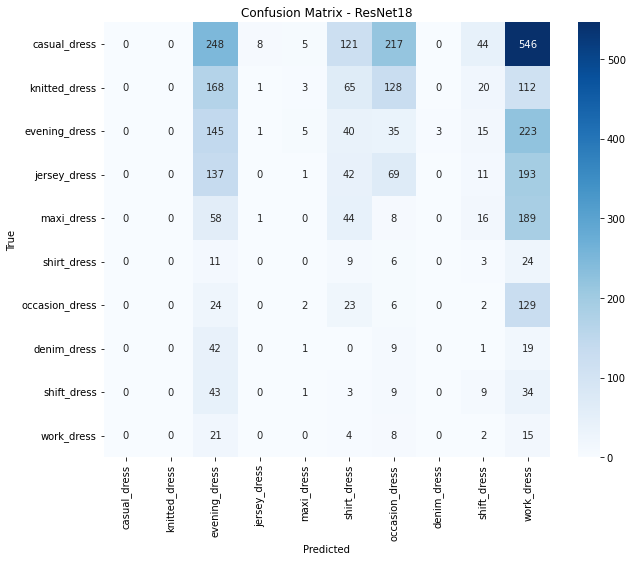

MLP Test Accuracy: 0.1221


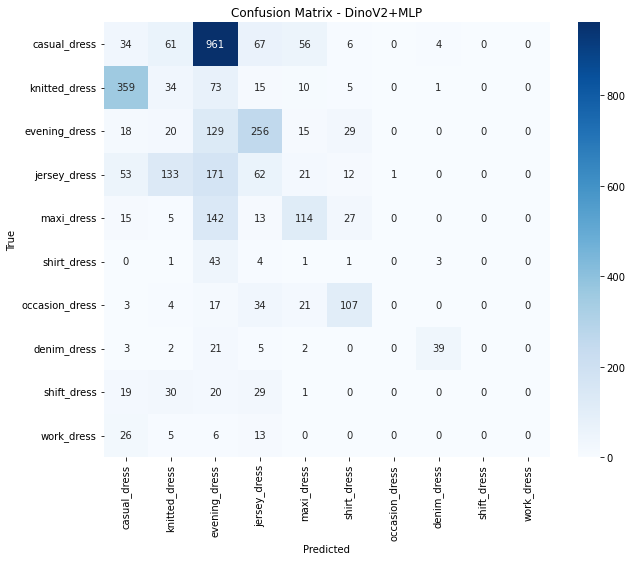

In [212]:
acc_resnet, cm_resnet = evaluate_model(model_resnet, test_loader, device)
print(f"ResNet18 Test Accuracy: {acc_resnet:.4f}")
plot_confusion_matrix(cm_resnet, class_names, "Confusion Matrix - ResNet18")

acc_mlp, cm_mlp = evaluate_model(model_mlp, test_feature_loader, device)
print(f"MLP Test Accuracy: {acc_mlp:.4f}")
plot_confusion_matrix(cm_mlp, class_names, "Confusion Matrix - DinoV2+MLP")

ResNet18 performs poorly with a test accuracy of 0.0544, showing heavy misclassification across all classes-- most notably predicting work_dress for many unrelated inputs.

The DinoV2+MLP model shows strong bias toward predicting casual_dress (961 times), inflating its count regardless of the true class. Despite a low test accuracy of 0.1221, it captures some structure. for example, evening_dress, jersey_dress, and maxi_dress have modest diagonal values—but still suffers from major confusion across categories.

### Qualitative Analysis (Error Analysis):

Randomly sample and display (show the image, its true label, and the model's predicted label):
1. 5 images from the test set that were correctly classified by the model.
2. 5 images from the test set that were misclassified by the model.
3. For the misclassified examples, try to understand why the model might've made the mistake.
4. Are there common visual patterns in the misclassified images for a particular category?
5. Are the images inherently ambiguous (i.e., even a human might struggle)?
6. Does one model (DinoV2+MLP vs. CNN) seem to struggle with different types of errors than the other?

Using device: cuda
no. of classes: 10

Training with batch_size=64, hidden_layers=[256], lr=0.01

Epoch 1/50
Train Loss: 1.5873 | Train Acc: 0.4633 | Val Loss: 2.2530 | Val Acc: 0.3492
validation loss improved (inf --> 2.2530). Saving model...
Current LR: 0.01

Epoch 2/50
Train Loss: 1.4803 | Train Acc: 0.4790 | Val Loss: 2.5736 | Val Acc: 0.3622
no improvement in validation loss for 1 epochs.
Current LR: 0.01

Epoch 3/50
Train Loss: 1.4388 | Train Acc: 0.4955 | Val Loss: 2.4656 | Val Acc: 0.3259
no improvement in validation loss for 2 epochs.
Current LR: 0.01

Epoch 4/50
Train Loss: 1.4299 | Train Acc: 0.5054 | Val Loss: 2.4128 | Val Acc: 0.3551
no improvement in validation loss for 3 epochs.
Early stopping triggered.
Stopping early at epoch 4
Best val accuracy: 0.3622, Training time: 0.8s

Training with batch_size=64, hidden_layers=[256], lr=0.005

Epoch 1/50
Train Loss: 1.4412 | Train Acc: 0.4949 | Val Loss: 2.3197 | Val Acc: 0.3474
validation loss improved (inf --> 2.3197). Saving 

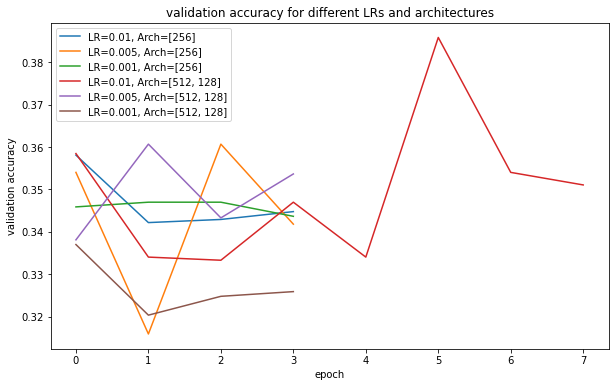

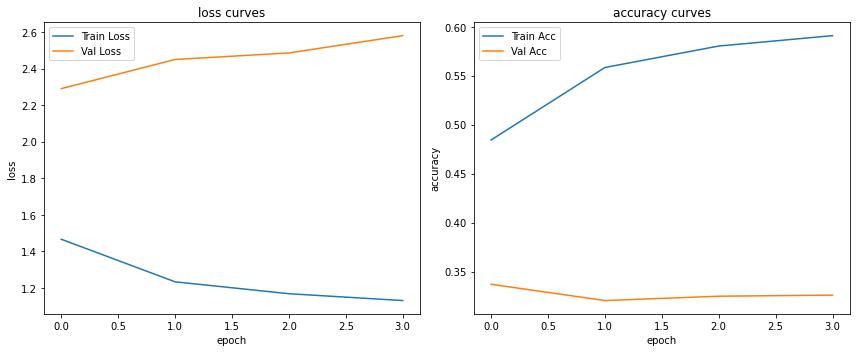

In [125]:
import time
def run_experiments():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    input_dim = 384  
    train_features, train_labels = load_data('train')
    val_features, val_labels = load_data('valid')

    num_classes = len(np.unique(train_labels))
    print(f'no. of classes: {num_classes}')

    train_features = torch.tensor(train_features, dtype=torch.float32)  #convert to tensors
    train_labels = torch.tensor(train_labels, dtype=torch.long)
    val_features = torch.tensor(val_features, dtype=torch.float32)
    val_labels = torch.tensor(val_labels, dtype=torch.long)

    learning_rates = [1e-2, 5e-3, 1e-3]  # trying some LR ranges
    hidden_layer_options = [[256], [512, 128]]  # start simple, gets more complex
    batch_sizes = [64, 128]
    epochs = 50
    patience = 3  # <-- Reduced early stopping patience

    results = []
    histories = {}  # to store histories keyed by (hidden_dims, lr)

    for batch_size in batch_sizes:
        train_dataset = TensorDataset(train_features, train_labels)
        val_dataset = TensorDataset(val_features, val_labels)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        for hidden_dims in hidden_layer_options:
            for lr in learning_rates:
                print(f'\nTraining with batch_size={batch_size}, hidden_layers={hidden_dims}, lr={lr}')
                model = DressesMLP(input_dim, hidden_dims, num_classes, dropout=0.4)
                criterion = torch.nn.CrossEntropyLoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # add weight_decay
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

                start_time = time.time()
                model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs, patience)
                elapsed = time.time() - start_time

                best_val_acc = max(history['val_acc'])
                print(f'Best val accuracy: {best_val_acc:.4f}, Training time: {elapsed:.1f}s')

                results.append({
                    'batch_size': batch_size,
                    'hidden_layers': hidden_dims,
                    'learning_rate': lr,
                    'best_val_acc': best_val_acc,
                    'train_time_sec': elapsed
                })

                histories[(tuple(hidden_dims), lr)] = history

    results_df = pd.DataFrame(results)

    summary_df = results_df.sort_values(by='best_val_acc', ascending=False).reset_index(drop=True)
    print("\nSummary of experiments (top 5):")
    print(summary_df.head(5).to_string(index=False))

    best_row = summary_df.iloc[0]
    print("\nFinal chosen hyperparameters:")
    print(best_row.to_string())
    print('\nAll experiments completed.')

    plt.figure(figsize=(10,6))
    for hidden_dims in hidden_layer_options:
        for lr in learning_rates:
            key = (tuple(hidden_dims), lr)
            if key in histories:
                plt.plot(histories[key]['val_acc'], label=f'LR={lr}, Arch={hidden_dims}')
    plt.xlabel('epoch')
    plt.ylabel('validation accuracy')
    plt.title('validation accuracy for different LRs and architectures')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('loss curves')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('accuracy curves')
    plt.legend()

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    run_experiments()

In [228]:
def unnormalize(img_tensor):
    """
    Undo ImageNet normalization on a tensor image and convert to numpy array for plotting.
    """
    img = img_tensor.numpy().transpose((1, 2, 0))  # C,H,W to H,W,C
    img = (img * imagenet_std) + imagenet_mean
    img = np.clip(img, 0, 1)
    return img

def show_classification_samples(
    model,
    dataloader,
    device,
    class_names,
    num_correct=5,
    num_incorrect=5,
    is_feature_model=False
):
    """
    Display random samples of correctly and incorrectly classified images or features.
    """
    model.eval()
    correct_samples = []
    incorrect_samples = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(len(labels)):
                img = inputs[i].cpu()
                true_label = labels[i].item()
                pred_label = preds[i].item()

                if true_label == pred_label and len(correct_samples) < num_correct:
                    correct_samples.append((img, true_label, pred_label))
                elif true_label != pred_label and len(incorrect_samples) < num_incorrect:
                    incorrect_samples.append((img, true_label, pred_label))

                if len(correct_samples) >= num_correct and len(incorrect_samples) >= num_incorrect:
                    break

            if len(correct_samples) >= num_correct and len(incorrect_samples) >= num_incorrect:
                break

    def plot_samples(samples, title, is_feature_model):
        plt.figure(figsize=(15, 3))
        for i, (img, true_label, pred_label) in enumerate(samples):
            ax = plt.subplot(1, len(samples), i + 1)
            if is_feature_model:
                # For feature-based model, no image to show, just text
                plt.text(
                    0.5, 0.5,
                    f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}",
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=12
                )
                plt.axis('off')
            else:
                img_np = unnormalize(img)
                plt.imshow(img_np)
                color = 'green' if true_label == pred_label else 'red'
                plt.title(
                    f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}",
                    color=color
                )
                plt.axis('off')
        plt.suptitle(title)
        plt.show()

    plot_samples(correct_samples, "Correctly Classified Samples", is_feature_model)
    plot_samples(incorrect_samples, "Misclassified Samples", is_feature_model)

    return correct_samples, incorrect_samples

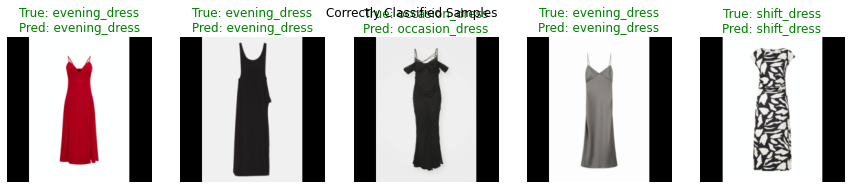

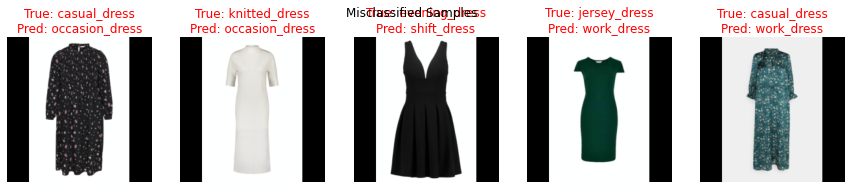

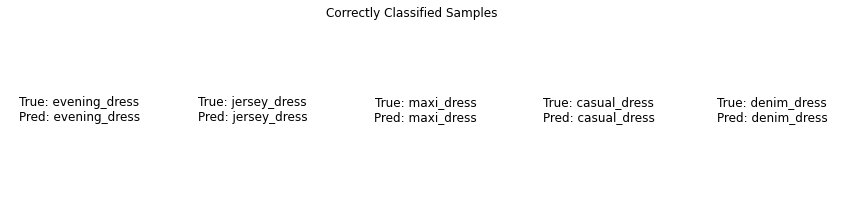

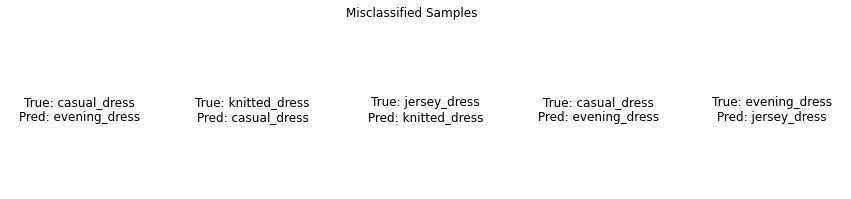

In [229]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

correct_resnet, incorrect_resnet = show_classification_samples(
    model_resnet, test_loader, device, class_names, is_feature_model=False
)

correct_mlp, incorrect_mlp = show_classification_samples(
    model_mlp, test_feature_loader, device, class_names, is_feature_model=True
)

In [183]:
# Qualitative error analysis: show images with true and predicted labels
def qualitative_analysis(model, dataset, true_labels, pred_labels, class_names, num_samples=5):
    correct_indices = np.where(true_labels == pred_labels)[0]        # find indices of correct and incorrect predictions
    incorrect_indices = np.where(true_labels != pred_labels)[0]

    def show_samples(indices, title):
        print(f"\n{title}:")
        samples = random.sample(list(indices), min(num_samples, len(indices)))
        plt.figure(figsize=(15, 3 * len(samples)))
        for i, idx in enumerate(samples):
            img, label = dataset[idx]
            #for visualization, i will undo normalization
            img_np = img.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_np = std * img_np + mean
            img_np = np.clip(img_np, 0, 1)

            plt.subplot(len(samples), num_samples, i + 1)
            plt.imshow(img_np)
            plt.axis('off')
            plt.title(f"True: {class_names[label]}\nPred: {class_names[pred_labels[idx]]}")
        plt.show()

    show_samples(correct_indices, "Correctly Classified Samples")
    show_samples(incorrect_indices, "Misclassified Samples")